In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from tqdm import tqdm
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer

## EDA 1: High-level Analysis of Python over the Years

In [2]:
# Read processed_data.csv
df_new = pd.read_csv("processed_data.csv")

In [3]:
# Obtain and inspect the correct columns
df_tags = df_new[['month', "Tags-2"]]
df_tags.drop_duplicates(inplace=True)
print(df_tags.shape)
df_tags.head(20)

(371501, 2)


<ipython-input-3-31da28f371fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tags.drop_duplicates(inplace=True)


,month,Tags-2
0,2010-01,python
1,2010-01,syntax
3,2010-01,python-sphinx
5,2010-01,arrays
6,2010-01,numpy
7,2010-01,options
8,2010-01,output-formatting
10,2010-01,mysql
12,2010-01,class
14,2010-01,image


In [4]:
# Obtain the number of posts and tags for every month
questions = df_new.groupby('month').size().to_frame()
df_month = df_tags.groupby('month').size().to_frame()
df_month = pd.concat([df_month, questions], axis=1)
df_month.columns = ['tags', 'docs']
df_month.index = df_month.index.astype(str)
df_month.head(20)

,tags,docs
month,,
2010-01,1254,5799
2010-02,1223,5784
2010-03,1326,6299
2010-04,1235,5645
2010-05,1288,6169
2010-06,1342,6698
2010-07,1436,7653
2010-08,1395,7372
2010-09,1368,6837


In [5]:
# Check the total number of posts and tags obtained
print(df_month['docs'].sum())
print(df_tags['Tags-2'].nunique())

# Save to csv
# df_month.to_csv("python_counts.csv")

4117394
22007


<ipython-input-7-f85e9eea1ced>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax1.set_xticks(np.append(np.arange(0, 120, 12), 119), [])


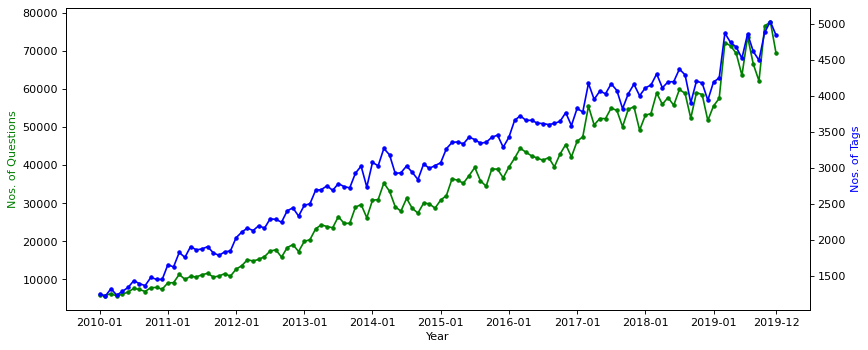

In [7]:
# Visualize the results
fig, ax1 = plt.subplots(figsize=(12, 5), dpi=80)

ax2 = ax1.twinx()
ax1.plot(df_month.index, df_month['docs'], 'g-', marker='.')
ax2.plot(df_month.index, df_month['tags'], 'b-', marker='.')

ax1.set_xlabel('Year')
ax1.set_ylabel('Nos. of Questions', color='g')
ax2.set_ylabel('Nos. of Tags', color='b')
ax1.set_xticks(np.append(np.arange(0, 120, 12), 119), [])

plt.show()


## 2. EDA 2: Analysis of Top Words over Time

In [8]:
# Read processed_data
#df_new = pd.read_csv("processed_data.csv")

In [9]:
# Split the data into separate years
df_2010 = df_new[df_new["yr"] == 2010]
df_2011 = df_new[df_new["yr"] == 2011]
df_2012 = df_new[df_new["yr"] == 2012]
df_2013 = df_new[df_new["yr"] == 2013]
df_2014 = df_new[df_new["yr"] == 2014]
df_2015 = df_new[df_new["yr"] == 2015]
df_2016 = df_new[df_new["yr"] == 2016]
df_2017 = df_new[df_new["yr"] == 2017]
df_2018 = df_new[df_new["yr"] == 2018]
df_2019 = df_new[df_new["yr"] == 2019]
df_2020 = df_new[df_new["yr"] == 2020]

dfs = [df_2010, df_2011, df_2012, df_2013, df_2014,
       df_2015, df_2016, df_2017, df_2018, df_2019]

### TFIDF

In [10]:
# Perform TFIDF per year
vecs = ['vec_2010', 'vec_2011', 'vec_2012', 'vec_2013', 'vec_2014',
        'vec_2015', 'vec_2016', 'vec_2017', 'vec_2018', 'vec_2019']
df_tfidf = []
for i, data in enumerate(dfs):
    vecs[i] = TfidfVectorizer(min_df=500, token_pattern=r"(?u)\S\S+")
    df_tfidf.append(vecs[i].fit_transform(data["Tags-3"]))
    print(df_tfidf[i].shape)

(81481, 66)
(127889, 114)
(193660, 168)
(296503, 250)
(363444, 291)
(432487, 338)
(507073, 367)
(623219, 426)
(675790, 448)
(815848, 507)


In [11]:
# Obtain the TFIDF score per word for all years and append to dataframe
year = np.arange(2010, 2020)
df_tag_over_time = pd.DataFrame(columns=["Year", "Term", "Rank"])
top10s = []

for i in range(len(vecs)):
    # sum tfidf frequency of each term through documents
    terms = vecs[i].get_feature_names()
    sums = df_tfidf[i].sum(axis=0)

    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append((year[i], term, sums[0, col]))

    year_ranking = pd.DataFrame(data, columns=['Year', 'Term','Rank'])
    year_ranking = year_ranking.sort_values(['Year', 'Rank'], ascending=False)
    top10 = list(year_ranking['Term'][1:11])
    top10s = top10s + top10
    df_tag_over_time = pd.concat([df_tag_over_time, year_ranking])
top10s = list(set(top10s))
df_tag_over_time

,Year,Term,Rank
44,2010,python,37810.009108
10,2010,django,8312.146220
17,2010,google-app-engine,3368.361745
27,2010,list,1769.661046
48,2010,regex,1561.945521
...,...,...,...
448,2019,tf-idf,391.211973
131,2019,file-io,390.852700
169,2019,h5py,389.774780
52,2019,canvas,389.771690


In [12]:
# Filter the results to the top 10 ranks
df_top10 = df_tag_over_time[df_tag_over_time['Term'].isin(top10s)]
df_top10["Ranking"] = df_top10.groupby('Year')['Rank'].rank(ascending=False)
df_top10

<ipython-input-12-9c016c04fa9f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10["Ranking"] = df_top10.groupby('Year')['Rank'].rank(ascending=False)


,Year,Term,Rank,Ranking
10,2010,django,8312.146220,1.0
17,2010,google-app-engine,3368.361745,2.0
27,2010,list,1769.661046,3.0
48,2010,regex,1561.945521,4.0
55,2010,string,1491.339269,5.0
...,...,...,...,...
425,2019,string,7312.937419,15.0
107,2019,django-models,4633.153587,16.0
495,2019,windows,4282.566429,17.0
220,2019,linux,3139.816331,18.0


In [13]:
# Transform the data for visualization
df_cross = pd.crosstab(columns = df_top10["Term"],
           index = df_top10["Year"],
           values = df_top10["Ranking"], aggfunc=sum)
df_bump = df_cross.melt(ignore_index=False).reset_index()
df_bump = df_bump.rename(columns={'value':"Rank"})
df_bump = df_bump[df_bump['Rank'] <= 10]

# Words with only 1 entry is dropped
df_bump = df_bump[~df_bump.Term.isin(['csv',
                                      'django-models',
                                      'keras',
                                      'linux'])]

#df_bump.to_csv("words_rank.csv")

In [15]:
# Check obtained words
df_bump.groupby("Term").size()

Term
dataframe             4
dictionary            9
django               10
flask                 2
google-app-engine     3
list                 10
matplotlib            9
numpy                10
pandas                7
python-2.7            7
python-3.x            9
regex                 6
string                5
tensorflow            3
windows               2
dtype: int64

In [18]:
# Visualize the results
#df_bump = pd.read_csv('words_rank.csv')

n_top_ranked = 10
top_sources = (df_bump[df_bump["Year"] == df_bump["Year"].max()]
               .nsmallest(n_top_ranked, "Rank"))

highlight = alt.selection(type='single', on='mouseover',
                          fields=['Term'], nearest=True, empty="none")

chart = alt.Chart(df_bump).mark_line().encode(
        x=alt.X('Year'),
        y=alt.Y('Rank', scale=alt.Scale(domain=[10, 1])),
        color='Term',
        strokeDash='Term',
        #color=alt.condition(highlight, 'Term', alt.value("lightgray")),
        tooltip=['Rank','Term']
    ).properties(
        width=780,
        height=400
    )

points = alt.Chart(df_bump).mark_point(opacity=0).encode(
        x='Year',
        y='Rank',
        color=alt.Color("Term"))

layer = chart + points
layer
#https://stackoverflow.com/questions/62206463/how-to-color-lines-on-mouseover-in-a-bump-chart-using-altair-viz

alt.LayerChart(...)

## EDA3: Topic Content Analysis

In [19]:
# Read the excel file containing the topics
df_excel = pd.read_excel('svd_topics.xlsx',
                          sheet_name="topics").iloc[:, 1:].dropna(how='all')
df_excel

,Generic Python,Django Framework,Web App,Python Data Types,Web Scraping,GUI Tools,Python Version 2.7,Computations Tools,Python Version 3,Data Transformation,Deep Learning,Machine Learning,Unnamed: 13,Unnamed: 14
0,"('python', 0.9943218682525379)","('django', 0.9880502723563694)","('google-app-engine', 0.9983521744661842)","('list', 0.9404907529312443)","('regex', 0.8422051965282726)","('windows', 0.9468411014784877)","('python-2.7', 0.7769092657424509)","('numpy', 0.879251178916456)","('python-3.x', 0.9374201668067704)","('pandas', 0.8268187426571936)","('tensorflow', 0.8531239775608215)","('numpy', 0.9105799158252526)",NaN,NaN
1,"('django', 0.09502222831042192)","('django-models', 0.09197634801382917)","('java', 0.016267823489153576)","('string', 0.2367570808609068)","('string', 0.47361778566018253)","('linux', 0.25072191543097255)","('python-3.x', 0.3130541743979987)","('scipy', 0.20412407327137788)","('list', 0.24451087544188038)","('dataframe', 0.27107233849187656)","('keras', 0.3829851406612613)","('tensorflow', 0.23383672826400823)",NaN,NaN
2,"('google-app-engine', 0.02812175927549381)","('google-app-engine', 0.03767880399739542)","('javascript', 0.014800116339071318)","('dictionary', 0.19079408926791833)","('parsing', 0.05954310325495384)","('tkinter', 0.1370226656972121)","('regex', 0.19393612047325756)","('matplotlib', 0.1890413242369029)","('dictionary', 0.10853479824120318)","('python-3.x', 0.1636473685165283)","('machine-learning', 0.21301822576905416)","('arrays', 0.16907906792251923)",NaN,NaN
3,"('list', 0.011799436896301897)","('django-templates', 0.03135524552257426)","('html', 0.008156884218153734)","('regex', 0.13005489881680654)","('html', 0.05151756918950376)","('macos', 0.06539262338682207)","('tkinter', 0.04106495522121007)","('arrays', 0.12430074120619991)","('string', 0.0705282740423107)","('numpy', 0.1589292431475108)","('deep-learning', 0.15093084767307016)","('keras', 0.15399737416248854)",NaN,NaN
4,"('regex', 0.010085786898777175)","('django-forms', 0.03135025797705695)","('json', 0.00797471848220162)","('performance', 0.04302840382490761)","('unicode', 0.04931691668393038)","('c++', 0.04918504736690188)","('windows', 0.023379789050699564)","('performance', 0.025561204029968407)","('tkinter', 0.0629190319545653)","('python-2.7', 0.13618675206703384)","('neural-network', 0.10466030385016119)","('matplotlib', 0.11851924930003034)",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,"('numpy', 0.07211774915423473)","('django-views', 0.0489867075471738)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,"('matplotlib', 0.04293898596017816)","('django-forms', 0.04464831693019766)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,"('tensorflow', 0.04023276333727933)","('dataframe', 0.03703042026961838)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,"('list', 0.033542524307498565)","('django-templates', 0.028733410244083588)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Create a list as placeholder for all topics
df_excels = ['df_excel0', 'df_excel1', 'df_excel2', 'df_excel3',
             'df_excel4', 'df_excel5', 'df_excel6', 'df_excel7', 
             'df_excel8', 'df_excel9', 'df_excel10', 'df_excel11']

<ipython-input-21-d2f5ada1590a>:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df = (df_excel[str(df_excel.columns[i])].str.replace('(', ''))
<ipython-input-21-d2f5ada1590a>:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df = df.str.replace(')', '')


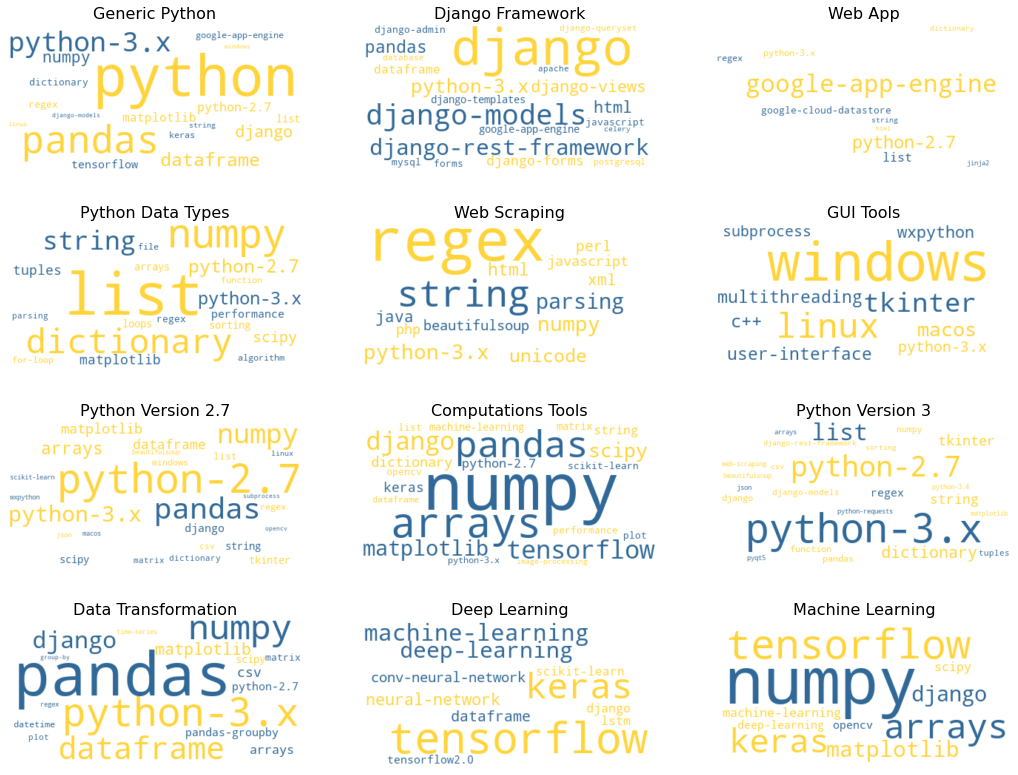

In [21]:
# Create a word cloud per topic
import matplotlib.colors

#colorsList = [(tuple rgb color 1),(tuple rgb color 2),(tuple rgb color 3)]
CustomCmap = matplotlib.colors.ListedColormap(['#FFD43B', '#306998'])

dct = {}
fig, axs = plt.subplots(4, 3, figsize=(18, 14))
axs = axs.ravel()

for i, df in enumerate(df_excels):
    df = (df_excel[str(df_excel.columns[i])].str.replace('(', ''))
    df = df.str.replace(')', '')
    df = df.str.replace("'", '')
    df = df.str.split(',').dropna()

    dct = {}
    for a, x in df.values:
        dct[a] = float(x)

    wordcloud = WordCloud(background_color="white", min_font_size=8, colormap=CustomCmap,
                          prefer_horizontal=1).generate_from_frequencies(frequencies=dct)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(str(df_excel.columns[i]), fontsize=16)
    axs[i].axis("off")
#plt.tight_layout()
plt.show()

## EDA 4: Topics through Time

In [22]:
# Read excel file
df_excel = pd.read_excel('svd_topics.xlsx',
                          sheet_name="topics_summary",
                          index_col=0)
topics = df_excel.melt(ignore_index=False).reset_index()
topics.columns = ["Year", "SV", "Topic"]

In [23]:
# Transform the data for visualization
topics_cross = pd.crosstab(columns = topics["Topic"],
           index = topics["Year"],
           values = topics["SV"], aggfunc=sum)
df_topics = topics_cross.melt(ignore_index=False).reset_index()
df_topics = df_topics.rename(columns={'value':"SV"})
df_topics.fillna(7, inplace=True)

#df_topics.to_csv('topics_ranks.csv')

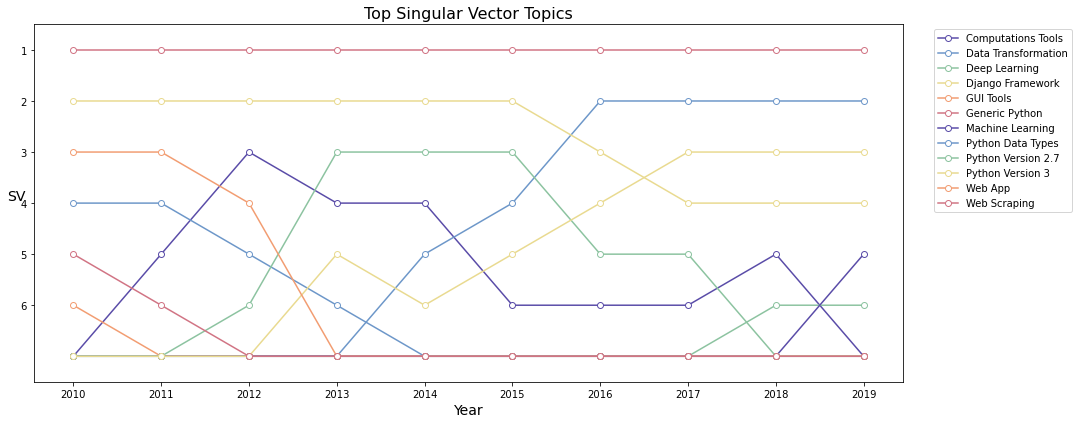

In [24]:
# Try visualization using matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

df_topics = pd.read_csv('topics_ranks.csv')
n_top_ranked = 7
top_sources = (df_topics[df_topics["Year"] == df_topics["Year"].max()]
               .nsmallest(n_top_ranked, "SV"))
top_sources

colors = ['#5A4CA8', '#6D97C9', '#8CC3A0', '#E9DA90', '#F29D72', '#D17484',
          '#5A4CA8', '#6D97C9', '#8CC3A0', '#E9DA90', '#F29D72', '#D17484']

fig, ax = plt.subplots(figsize=(15, 6),
                       subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))


cnt = 0
for i, j in df_topics.groupby("Topic"):
    ax.plot('Year', "SV", 'o-', data=j, mfc="w", color=colors[cnt], label=i)
    ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', )
    cnt += 1
    
ax.invert_yaxis()
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("SV", fontsize=14, rotation=0)
ax.set_title("Top Singular Vector Topics", fontsize=16)
ax.set_yticks([1, 2, 3, 4, 5, 6])
#ax.grid(axis="x")
plt.tight_layout()
plt.show()

In [25]:
# Try visualization using altair

highlight = alt.selection(type='single', on='mouseover',
                          fields=['Topic'], nearest=True, empty="none")


chart = alt.Chart(df_topics).mark_line().encode(
        x='Year',
        y=alt.Y('SV', 
                scale=alt.Scale(domain=(7.5, 0.5), clamp=True), 
                axis=alt.Axis(tickCount=6, titleAngle=0, titlePadding=15,
                             labelColor=alt.condition('datum.value > 6',
                                                      alt.value('white'),
                                                      alt.value('black')))),
        color=alt.Color('Topic', 
                        legend=alt.Legend(title="Topics")),
        strokeDash=alt.Stroke('Topic',
                              legend=None),
        #color=alt.condition(highlight, 'Topic', alt.value("lightgray")),
        size=alt.condition(~highlight, alt.value(1), alt.value(4)),
        tooltip=['SV','Topic'],
).properties(
    width=780,
    height=400
)

points = alt.Chart(df_topics).mark_point(opacity=1).encode(
        x='Year',
        y='SV',
        color=alt.Color("Topic", legend=None)).add_selection(
    highlight
)


layer.configure_axis(
    grid=False
).add_selection(
    highlight
)

layer = chart + points

layer

alt.LayerChart(...)